# Fitted Q iteration

code and idea lifted from:

https://blog.griddynamics.com/building-a-next-best-action-model-using-reinforcement-learning/

and

https://github.com/ikatsov/tensor-house/blob/master/promotions/next-best-action-rl.ipynb

actual paper:
https://www.jmlr.org/papers/volume6/ernst05a/ernst05a.pdf

orig algo from this paper


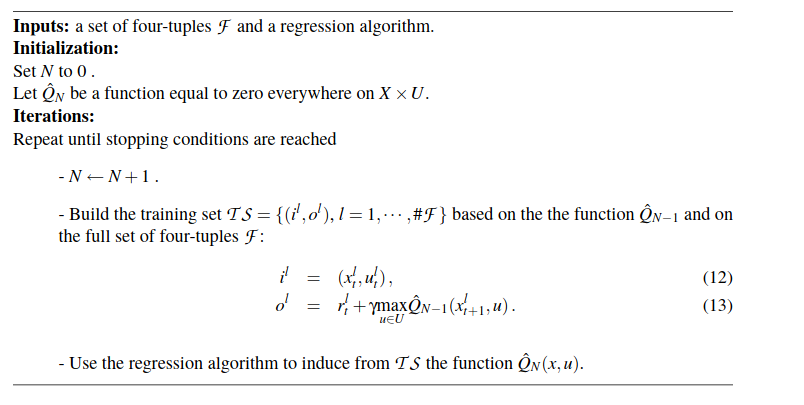

https://proceedings.neurips.cc/paper/2008/file/f79921bbae40a577928b76d2fc3edc2a-Paper.pdf

advantage fitted iteration:

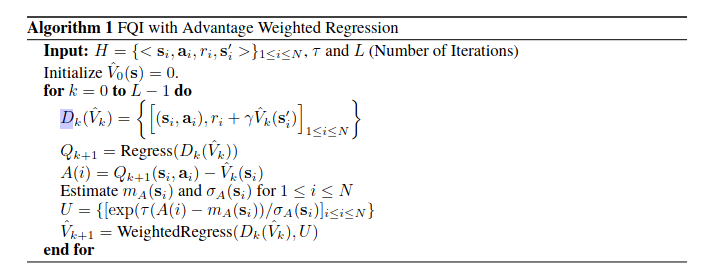

# set up sample data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

plt.rcParams.update({'font.size': 14, 'pdf.fonttype': 'truetype'})
plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})



In [2]:
#
# Environment parameters
#
events = [
    0, # no action
    1, # visit
    2  # purchase
]
offers = [
    1, # advertisement
    2, # small disocunt
    3  # large discount
]
demogr = [
    0, # low sensitivity
    1  # high sensitivity
]

n = 1000 # users
k = 100  # time intervals
m = 3    # offers

#
# Auxiliary functions
#
def multinomial_int(p):
    return np.where(np.random.multinomial(1, p) == 1)[0][0]

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

def find_offer_times(f):
    return np.nonzero(f)[0]

def offer_seq(f):
    return f[np.where(f > 0)]

#
# Environment simulator
#
def get_event_pr(d, f):
    f_ids = offer_seq(f) 
    f_ids = np.concatenate((f_ids, np.zeros(3 - len(f_ids))))
    
    if((f_ids[0] == 1 and f_ids[1] == 3) or 
       (f_ids[1] == 1 and f_ids[2] == 3) or 
       (f_ids[0] == 1 and f_ids[2] == 3)): 
            p_events = [0.70, 0.08, 0.22]     # higher probability of a purchase
    else:
        p_events = [0.90, 0.08, 0.02]         # default probability distribution over events
        
    if(np.random.binomial(1, 0.1) > 0):       # add some noise
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

def generate_profiles(n, k, m):
    
    p_offers = [1 / m] * m                                    # offer probabilities (behavioral policy)
    t_offers = np.linspace(0, k, m + 2).tolist()[1 : -1]      # offer campaing times
    t_offer_jit = 5                                           # offer time jitter, standard deviation in time units 
    
    P = np.zeros((n, k))                                      # matrix of profile events
    F = np.zeros((n, k))                                      # offer history
    D = np.zeros((n, 1))                                      # demographic features

    for u in range(0, n):
        D[u, 0] = np.random.binomial(1, 0.5)
    
        # determine m time points to issue offers for customer u
        offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)
        
        for t in range(0, k):                                   # simulate a trajectory for customer u
            if t in offer_times_u:
                F[u, t] = multinomial_int(p_offers) + 1         # issue an offer at time t according 
                                                                # to the behavioral policy 
   
            event = multinomial_int(get_event_pr(D[u], F[u]))   # simulate an event at time t
            P[u, t] = event
        
    return P, F, D

def visualize_profiles(m):
    
    max_val = np.max(m)
    colors = []
    if max_val == 2:
        colors = ['white', '#fde725', '#35b779']
    if max_val == 3:
        colors = ['white', '#440154', '#21918c', '#fde725']
    cmap = matplotlib.colors.ListedColormap(colors)
    
    fig, ax = plt.subplots(figsize=(10, 20))
    chart = ax.imshow(m, cmap=cmap, interpolation='none')
    ax.set_aspect(0.5 * m.shape[1] / m.shape[0])
    ax.grid(True)
    ax.set_xlabel('Time')
    ax.set_ylabel('User ID')
    plt.colorbar(chart, fraction=0.025, pad=0.04, ax=ax)
    plt.show() 
    


findfont: Font family ['Candara'] not found. Falling back to DejaVu Sans.


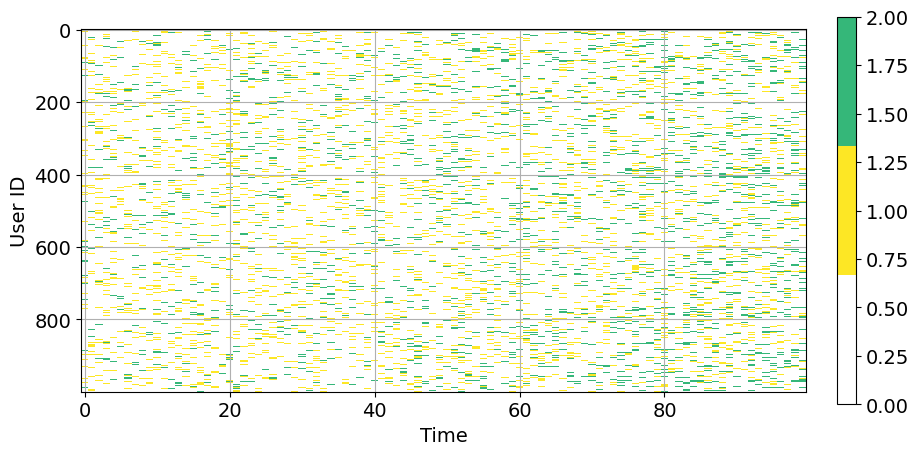

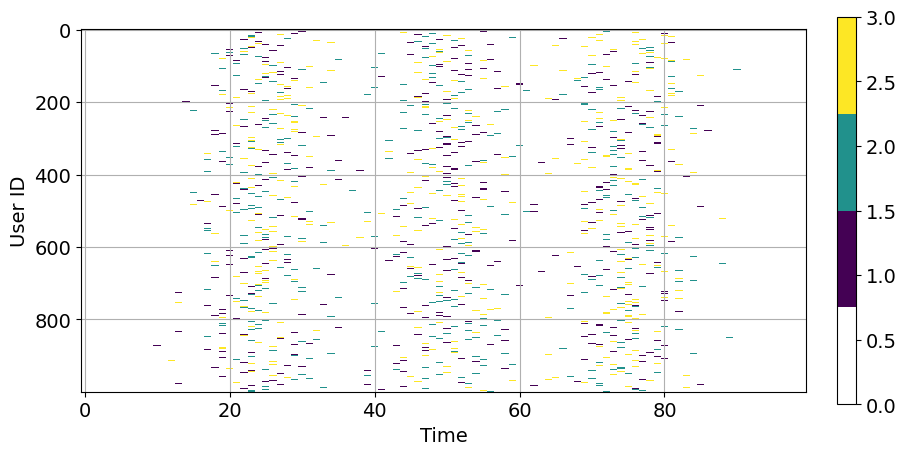

In [3]:
P, F, D = generate_profiles(n, k, m)          # training set
Pt, Ft, Dt = generate_profiles(n, k, m)       # test set

visualize_profiles(P)
visualize_profiles(F)

In [4]:
#
# Cut trajectories into transitions
#
def state_features(p, f, d, t_start, t_end):
    p_frame = p[0:t_end]
    f_frame = f[0:t_end]
    f1 = index(f_frame, 1, k)  
    f2 = index(f_frame, 2, k)
    f3 = index(f_frame, 3, k)
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # number of visits
        f1,                    # first time offer 1 was issued
        f2,                    # first time offer 2 was issued
        f3                     # first time offer 3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start:t_end], 2)   # number of purchases in the time frame

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))
    
def prepare_trajectories(P, F, D):
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            is_end_of_trajectory = t_end >= k
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 # default action
                
            T_u.append([state, action, reward, state_new, is_end_of_trajectory])
            
        T.append(T_u) 
        
    return np.array(T, dtype=object)

T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)


In [5]:
T.shape

(1000, 4, 5)

In [6]:
Tt.shape

(1000, 4, 5)

In [7]:
#
# Find the optimal action under a greedy policy and corresponding state value
#
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

def Q_0(sa):
    return [1]

total_reward_orig = 0

Q = Q_0
for i in range(1, 5): # FQI iterations
    X = []
    Y = []
    for sample in T.reshape((n * (m + 1), -1)):
        state, action, reward, state_new, is_end_of_trajectory = sample
        x = np.append(state, action) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, state_new, offers)
        
        y = reward + v_best    # we ignore the initial conditions (ends of trajectories) for the sake of illustration      
    
        X.append(x)
        Y.append(y)
        
        total_reward_orig += reward
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict

In [8]:
# Values of possible actions for a user who did not get any offer yet  
print(Q([[0, 0, 100, 100, 100, 1]]))
print(Q([[0, 0, 100, 100, 100, 2]]))
print(Q([[0, 0, 100, 100, 100, 3]]))

# Values of possible actions for a user who got offer #1 at time step 20  
print(Q([[0, 0, 20, 100, 100, 1]]))
print(Q([[0, 0, 20, 100, 100, 2]]))
print(Q([[0, 0, 20, 100, 100, 3]]))



[12.86350271]
[7.29959996]
[6.06622238]
[13.09476821]
[13.09476821]
[17.32225233]


In [9]:
#
# Use the test set to evaluate the policy
#
states = np.array(Tt[:, :, 0].flatten().tolist())

values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best)
    
s_tsne = TSNE(learning_rate = 100).fit_transform(states)



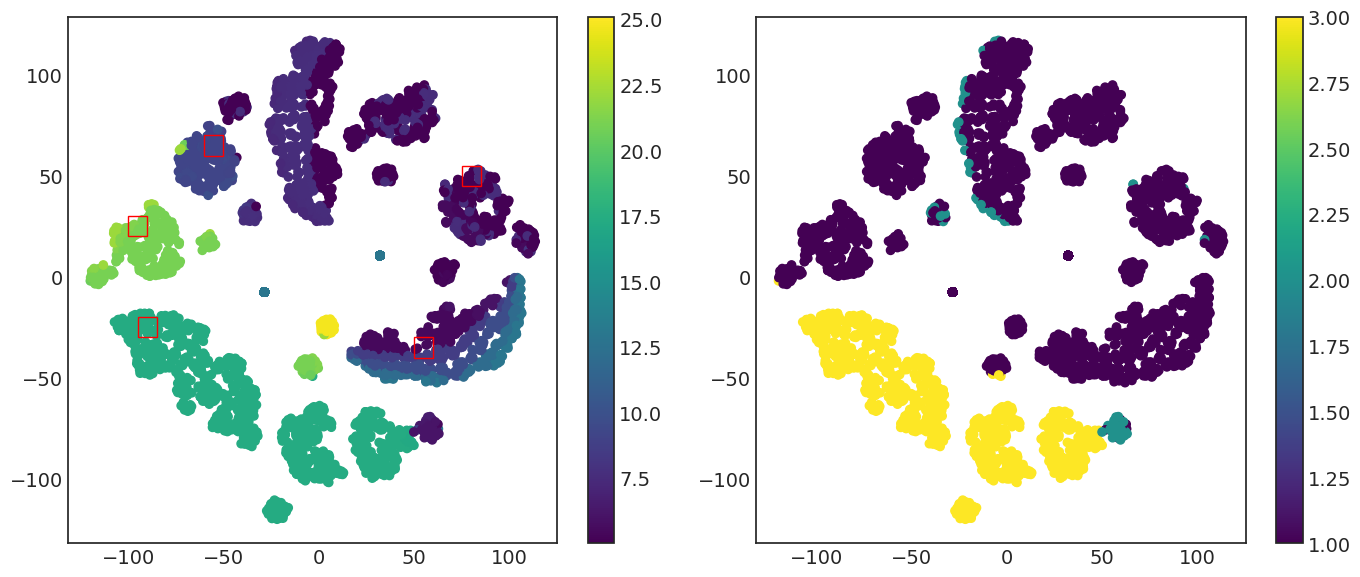

Segment ((-95, -85), (-30, -20)):
 [[ 20. 100. 100.]
 [ 19. 100. 100.]
 [ 19. 100. 100.]
 [ 19. 100. 100.]
 [ 20. 100. 100.]]
Segment ((50, 60), (-40, -30)):
 [[100.  27. 100.]
 [100.  27. 100.]
 [100.  28. 100.]
 [100.  28. 100.]
 [100.  28. 100.]]
Segment ((75, 85), (45, 55)):
 [[100.  30.  39.]
 [100.  30.  39.]
 [100.  27.  44.]
 [100.  27.  46.]
 [100.  27.  46.]]
Segment ((-100, -90), (20, 30)):
 [[ 29. 100.  47.]
 [ 29. 100.  47.]
 [ 28. 100.  48.]
 [ 28. 100.  48.]
 [ 31. 100.  48.]]
Segment ((-60, -50), (60, 70)):
 [[ 54. 100.  24.]
 [ 53. 100.  26.]
 [ 54. 100.  26.]
 [ 54. 100.  26.]
 [ 55. 100.  25.]]


In [20]:
#
# Visualuze the Q-values and best action for individual users
#

#
# Segment boxes need to be set manually because the tSNE
# projection changes unpredictabley as the data changes  
#
segments = [
    ( (-95,-85), (-30, -20) ),
    ( (50, 60),   (-40, -30) ),
    ( (75,85), (45,55) ),
    ( (-100,-90),    (20,30) ),
    ( (-60,-50),    (60,70) )
]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
scatter = ax[0].scatter(s_tsne[:, 0], s_tsne[:, 1], c=values, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[0])
for s in segments:
    rect = Rectangle((s[0][0], s[1][0]), s[0][1] - s[0][0], s[1][1] - s[1][0], linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)


scatter = ax[1].scatter(s_tsne[:, 0], s_tsne[:, 1], c=best_actions, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[1])
plt.tight_layout()
plt.show()


for s in segments:
    segment = ((s_tsne[:, 0] > s[0][0]) & (s_tsne[:, 0] < s[0][1]) & (s_tsne[:, 1] > s[1][0]) & (s_tsne[:, 1] < s[1][1]))
    print(f'Segment {s}:\n', np.array(states)[segment, 2:][:5])

In [13]:
def make_epsilon_greedy_policy(Q, eps):
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        else:
            return eps / (m - 1)
        
    return egreedy_policy


# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        for transition in trajectory:            
            state, action, reward  = transition[0:3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)   


In [14]:
policy_returns = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_returns.append( evaluate_policy_return(T, behavioral_policy, policy) )

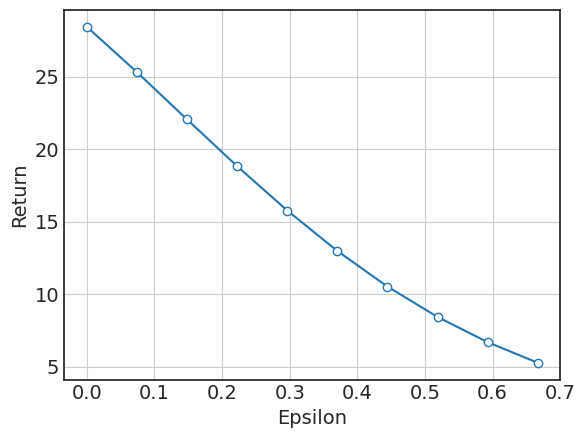

In [15]:
plt.style.use('seaborn-white')
plt.grid(True)
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_returns, '-o', mfc='w')
plt.show()

In [16]:
#
# Find the optimal action under a greedy policy and corresponding state value
# modified to not toss all the old data
# q can deal with off policy so lets keep the last half of the samples from prior ovservations
#
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

def Q_0(sa):
    return [1]

total_reward_mod = 0

Q = Q_0
for i in range(1, 5): # FQI iterations
    if i == 1:
        X = []
        Y = []
    else:
        X = X[-len(X)//2:]
        Y = Y[-len(Y)//2:]
        
    for sample in T.reshape((n * (m + 1), -1)):
        state, action, reward, state_new, is_end_of_trajectory = sample
        x = np.append(state, action) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, state_new, offers)
        
        y = reward + v_best    # we ignore the initial conditions (ends of trajectories) for the sake of illustration      
    
        X.append(x)
        Y.append(y)
        
        total_reward_mod += reward
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict

In [17]:
policy_returns = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_returns.append( evaluate_policy_return(T, behavioral_policy, policy) )

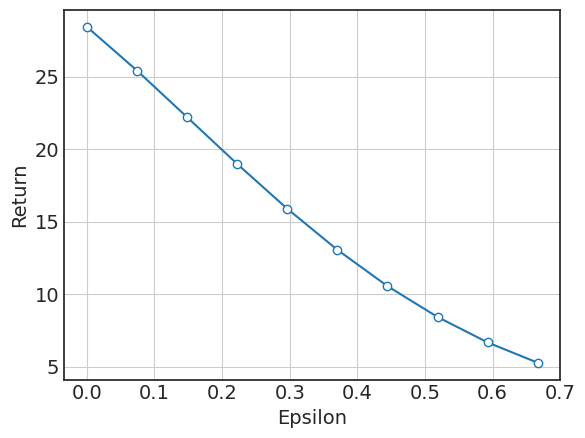

In [18]:
plt.style.use('seaborn-white')
plt.grid(True)
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_returns, '-o', mfc='w')
plt.show()

In [19]:
print(total_reward_orig)
print(total_reward_mod)

21156
21156
